In [1]:
import numpy as np
from tqdm import tqdm
from astropy.io import ascii
import pandas as pd

table = ascii.read('..\Fermi-LAT Data\hdu1.txt')
fermi_lat = table.to_pandas()
fermi_lat.to_csv('..\Fermi-LAT Data\hdu1.csv')


# ONE HOT ENCODING OF SPECTRUMTYPE

PLCount = np.zeros(len(fermi_lat['SpectrumType']))
LPCount = np.zeros(len(fermi_lat['SpectrumType']))
PLECCount = np.zeros(len(fermi_lat['SpectrumType']))

for i in range(0,len(fermi_lat['SpectrumType'])):
    if fermi_lat['SpectrumType'][i] == 'PowerLaw':
        PLCount[i] = 1
    if fermi_lat['SpectrumType'][i] == 'LogParabola':
        LPCount[i] = 1
    if fermi_lat['SpectrumType'][i] == 'PLSuperExpCutoff':
        PLECCount[i] = 1

fermi_lat['PL'] = PLCount
fermi_lat['LP'] = LPCount
fermi_lat['PLEC'] = PLECCount

fl = fermi_lat.drop(columns=['ROI_num','RA_Counterpart','DEC_Counterpart','Conf_68_SemiMajor', 'Conf_68_SemiMinor', 'Conf_68_PosAng',
       'Conf_95_SemiMajor', 'Conf_95_SemiMinor', 'Conf_95_PosAng','RAJ2000', 'DEJ2000','DataRelease','GLON','GLAT','Source_Name',
       'Extended_Source_Name','ASSOC_4FGL','ASSOC_FGL','ASSOC_FHL','ASSOC_GAM1','ASSOC_GAM2','ASSOC_GAM3','TEVCAT_FLAG',
       'ASSOC_TEV','CLASS1','CLASS2','ASSOC1','ASSOC2','Flags','SpectrumType'])

'''
The above columns are dropped because they are either positional data or non-numerical data.

Uncertainty data is also dropped below.

'''

#fl = fermi_lat.drop(columns=[])

fl_classes = fermi_lat['CLASS1']
fl_classes.to_csv('fl_classes.csv')

uncertainties = np.array([])
for x in fl.columns:
    if 'Unc' in x:
        uncertainties = np.append(uncertainties,x)
fl = fl.drop(columns=uncertainties)
print(fl.dtypes.value_counts())
fl.columns

float64    29
object      5
Name: count, dtype: int64


Index(['Signif_Avg', 'Pivot_Energy', 'Flux1000', 'Energy_Flux100',
       'PL_Flux_Density', 'PL_Index', 'LP_Flux_Density', 'LP_Index', 'LP_beta',
       'LP_SigCurv', 'LP_EPeak', 'PLEC_Flux_Density', 'PLEC_IndexS',
       'PLEC_ExpfactorS', 'PLEC_Exp_Index', 'PLEC_SigCurv', 'PLEC_EPeak',
       'Npred', 'Flux_Band', 'nuFnu_Band', 'Sqrt_TS_Band', 'Variability_Index',
       'Frac_Variability', 'Signif_Peak', 'Flux_Peak', 'Time_Peak',
       'Peak_Interval', 'Flux_History', 'Sqrt_TS_History', 'ASSOC_PROB_BAY',
       'ASSOC_PROB_LR', 'PL', 'LP', 'PLEC'],
      dtype='object')

In [2]:
col0 = np.zeros(len(fl))
col1 = np.zeros(len(fl))
col2 = np.zeros(len(fl))
col3 = np.zeros(len(fl))
col4 = np.zeros(len(fl))
col5 = np.zeros(len(fl))
col6 = np.zeros(len(fl))
col7 = np.zeros(len(fl))

columnlist = ['Flux_Band', 'nuFnu_Band', 'Sqrt_TS_Band',
       'Flux_History','Sqrt_TS_History']

for name in columnlist:    
    for i in range(0,len(fl)):
        obj_data = fl[name][i]
        obj_data = obj_data.replace('[','') 
        obj_data = obj_data.replace(']','') 
        obj_data = obj_data.replace('null','0')
        float_data = [float(idx) for idx in obj_data.split(',')]
        for x in range(0,len(float_data)):
            if float_data[x] == 0:
                float_data[x] = np.nan

        col0[i] = float_data[0]
        col1[i] = float_data[1]
        col2[i] = float_data[2]
        col3[i] = float_data[3]
        col4[i] = float_data[4]
        col5[i] = float_data[5]
        col6[i] = float_data[6]
        col7[i] = float_data[7]
    fl[name + '_0'] = col0
    fl[name+'_1'] = col1
    fl[name+'_2'] = col2
    fl[name+'_3'] = col3
    fl[name+'_4'] = col4
    fl[name+'_5'] = col5
    fl[name+'_6'] = col6
    fl[name+'_7'] = col7

fl = fl.drop(columns=columnlist)


fl.to_csv('..\Fermi-LAT Data\FL_numericalonly_nopositional.csv')

cl = pd.read_csv('..\\Fermi-LAT Data\\fl_classes_numerical.csv',index_col=0)


In [3]:
column_list = fl.columns
nan_count = np.zeros(len(column_list))


fl = fl.replace(np.inf,np.nan)
fl = fl.replace(-np.inf,np.nan)

'''
REPLACING ALL INFINITE VALUES WITH NaN BECAUSE SCIKIT LEARN CANNOT READ THEM
'''

for i in range(0,len(column_list)):
    n_nans = (1 - (fl[column_list[i]].count()/len(fl[column_list[i]]))) * 100
    #print('nans in ' + x + ': ' + str(n_nans))
    nan_count[i] = n_nans


nan_data = np.stack((column_list,nan_count),axis=1)
nc = pd.DataFrame(nan_data,columns=['Parameter','Percentage NaNs'])
nc = nc.drop([0])
#nc.to_csv('NaN_percentage_by_column.csv')

drop_cols = np.array([])

for i in range(1,len(nc)):
    if nc['Parameter'][i] == 'CLASS1':
        pass
    elif nc['Percentage NaNs'][i] >= 20 :
        nc_sub20 = nc.drop([i])
        drop_cols = np.append(drop_cols,nc['Parameter'][i])

#nc_sub20.to_csv('NaN_percentage_by_column_sub20.csv')

fl_sub20 = fl.drop(columns=drop_cols)

fl = fl_sub20.dropna()
print(drop_cols)

['PLEC_EPeak' 'Signif_Peak' 'Flux_Peak' 'Time_Peak' 'Peak_Interval'
 'Sqrt_TS_Band_0' 'Sqrt_TS_Band_1' 'Sqrt_TS_Band_6' 'Sqrt_TS_Band_7']


In [4]:
fl_cl = pd.merge(fl,cl,left_index=True,right_index=True)

fl_cl.dropna()

fl_cl.to_csv('..\\Fermi-LAT Data\\fl_numericalonly_nopositional_withclasses.csv')


mask1 = fl_cl['CLASS1'] == 4
mask2 = fl_cl['CLASS1'] == 0

fl_cl = fl_cl[~mask1]
fl_cl = fl_cl[~mask2]

fl.head()


C:\Users\ioanp\AppData\Local\Temp\ipykernel_29472\1428959186.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fl_cl = fl_cl[~mask2]


,Signif_Avg,Pivot_Energy,Flux1000,Energy_Flux100,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,LP_beta,LP_SigCurv,...,Flux_History_6,Flux_History_7,Sqrt_TS_History_0,Sqrt_TS_History_1,Sqrt_TS_History_2,Sqrt_TS_History_3,Sqrt_TS_History_4,Sqrt_TS_History_5,Sqrt_TS_History_6,Sqrt_TS_History_7
4,24.497220,2065.1467,7.024454e-10,7.807578e-12,1.690367e-13,2.081634,1.778363e-13,2.052470,0.037899,1.283201,...,1.005235e-08,1.039027e-08,7.926063,2.934573,5.890346,10.227452,7.208447,5.825856,6.605715,6.771310
8,17.982480,2729.5300,3.126771e-10,3.260804e-12,3.982322e-14,1.781085,4.578294e-14,1.580971,0.120901,2.630329,...,5.382383e-10,5.717380e-10,5.489984,6.748371,4.148643,3.687562,4.447480,3.358187,2.409387,3.989121
10,16.672523,3402.8190,2.461732e-10,2.441939e-12,2.144947e-14,1.817964,2.620644e-14,1.599259,0.160069,3.092949,...,4.227508e-10,2.305279e-10,4.456632,5.560203,3.472792,2.216244,5.653224,6.638917,3.212988,2.189012
11,6.391003,1996.2040,5.001652e-10,4.373159e-12,1.042069e-13,2.518880,1.426265e-13,2.641635,0.244720,3.182654,...,1.278859e-09,4.426620e-09,1.640509,1.532090,2.829532,1.396613,3.353302,1.379536,0.355682,1.406976
15,35.793106,1361.4604,2.543283e-09,1.877118e-11,1.397960e-12,2.465627,1.954656e-12,2.346217,0.385295,11.985063,...,2.499952e-08,2.423208e-08,7.291609,11.243773,8.355050,8.451601,9.179317,9.003687,9.184525,9.755785


PL
[4.39670259e-17 4.21686837e-17 4.04764001e-17 ... 3.11083944e-26
 3.11083282e-26 0.00000000e+00]


(0.0, 1000000000000.0)

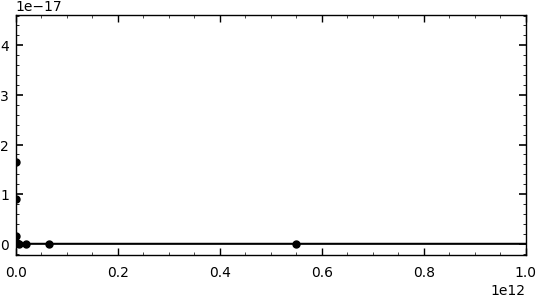

In [67]:
import matplotlib.pyplot as plt
from scipy.integrate import quad

def LogParabola(E,E_0,K,alpha,beta):
    # E is the independent variable, E_0 is the Pivot_Energy, K is LP_Flux_Density, alpha is LP_Index, and beta is LP_beta
    return K*((E/E_0)**(-alpha-(beta*np.log(E/E_0))))

def PLSuperExpCutoff(E,E_0,K,gamma,b,d):
    # E is the independent variable, E_0 is the Pivot_Energy, K is PLEC_Flux_Density, gamma is PLEC_Index, a is PLEC_Expfactor and b is PLEC_Exp_Index
    return K*((E/E_0)**((d/b)-gamma))*(np.exp((d/(b**2))*(1-(E/E_0)**b)))

def PowerLaw(E,E_0,K,gamma):
    # E is the independent variable, E_0 is the Pivot_Energy, K is PL_Flux_Density, gamma is PL_Index
    return K*((E/E_0)**(-gamma))

E = np.arange(50*10**6, 1*10**12,10**6)

index = 42
E_0 = fl['Pivot_Energy'][index]
K_pl = fl['PL_Flux_Density'][index]
gamma_pl = fl['PL_Index'][index]
K_plec = fl['PLEC_Flux_Density'][index]
gamma_plec = fl['PLEC_IndexS'][index]
d_plec = fl['PLEC_ExpfactorS'][index]
b_plec = fl['PLEC_Exp_Index'][index]
K_lp = fl['LP_Flux_Density'][index]
alpha_lp = fl['LP_Index'][index]
beta_lp = fl['LP_beta'][index]


fluxband = [fl['Flux_Band_0'][index],fl['Flux_Band_1'][index],fl['Flux_Band_2'][index],fl['Flux_Band_3'][index],fl['Flux_Band_4'][index],
            fl['Flux_Band_5'][index],fl['Flux_Band_6'][index],fl['Flux_Band_7'][index]]

# 50-100MeV, 100-300MeV, 300MeV-1GeV,1-3GeV,3-10GeV,10-30GeV,30-100GeV,100GeV-1TeV
locs = [75*10**6,200*10**6,650*10**6,2*10**9,6.5*10**9,20*10**9,65*10**9,550*10**9]
widths = [50*10**6,200*10**6,700*10**6,2*10**9,7*10**9,20*10**9,70*10**9,900*10**9]

avgN = np.array(fluxband)/np.array(widths)


#how many N between 2 energies, divide by width of limits to get average N
N=np.zeros(len(E-1))
if fermi_lat['SpectrumType'][index]=='LogParabola':
    print('LP')
    for i in range(0,len(E)-1):
        res1,err1=quad(LogParabola,E[i],E[i+1],args=(E_0,K_lp,alpha_lp,beta_lp))
        res = res1/10**6
        N[i]=res
elif fermi_lat['SpectrumType'][index] == 'PLSuperExpCutoff':
    print('PLEC')
    for i in range(0,len(E)-1):
        res1,err1=quad(PLSuperExpCutoff,E[i],E[i+1],args=(E_0,K_plec,gamma_plec,b_plec,d_plec))
        res = res1
        N[i]=res
elif fermi_lat['SpectrumType'][index] == 'PowerLaw':
    print('PL')
    for i in range(0,len(E)-1):
        res1,err1=quad(PowerLaw,E[i],E[i+1],args=(E_0,K_pl,gamma_pl))
        res = res1
        N[i]=res


fig, ax = plt.subplots()
ax.plot(E,N)
print(N)
ax.scatter(locs,avgN)
ax.set_xlim(0,10**(12))


Text(0, 0.5, 'Photon Flux (s cm2)')

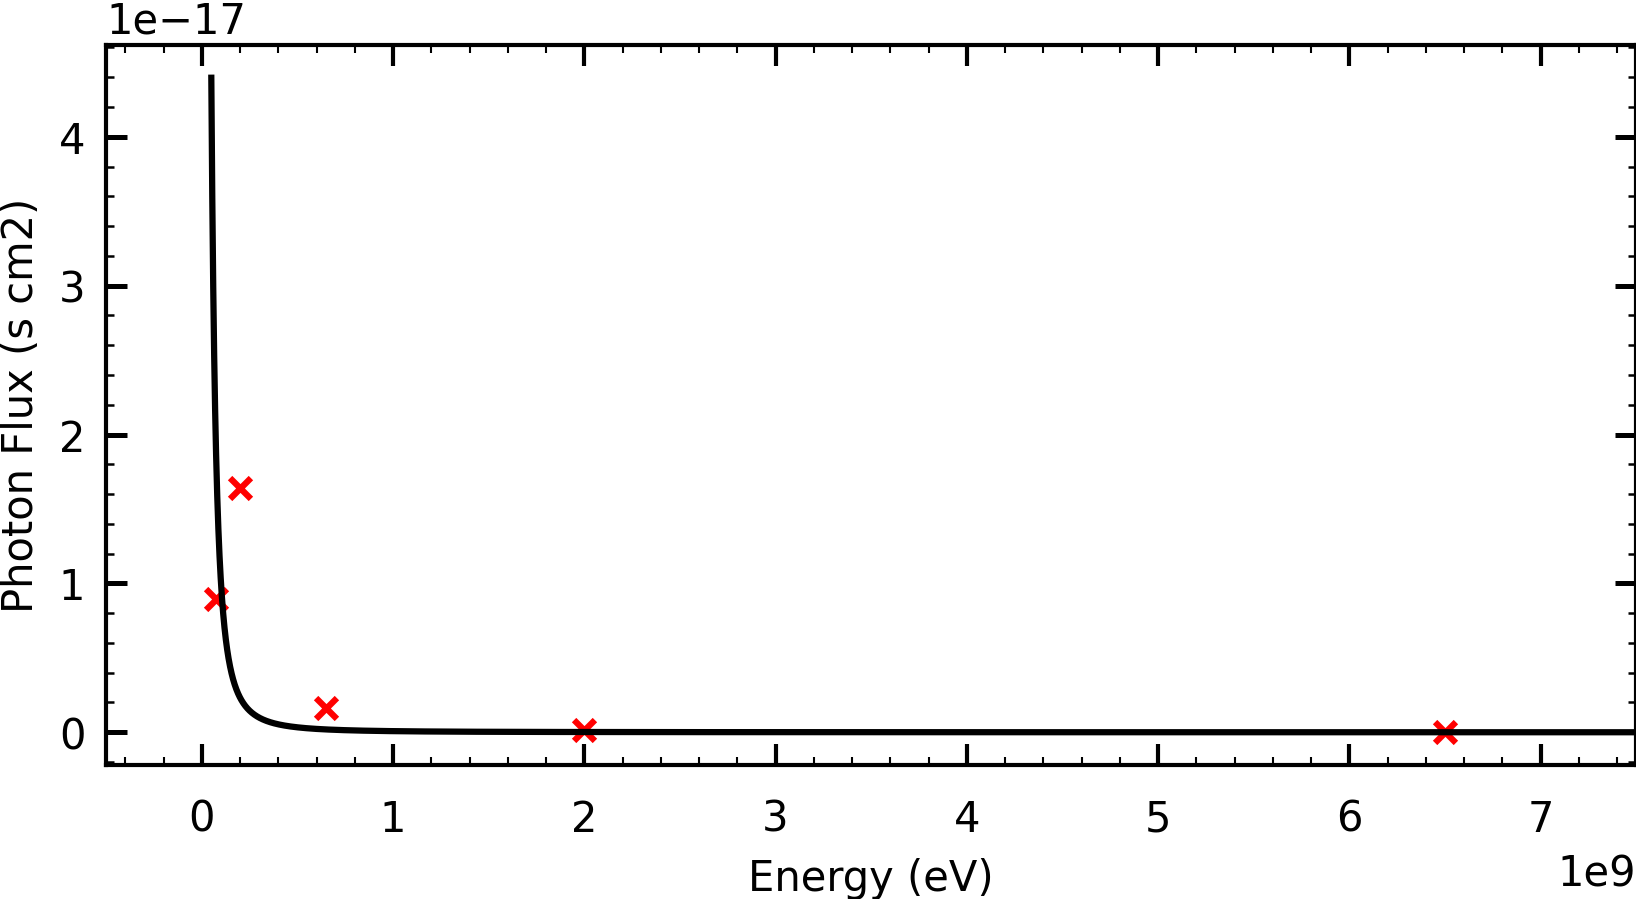

In [71]:
from os.path import basename, exists
def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download('https://github.com/AllenDowney/AstronomicalData/raw/main/' + 'az-paper-twocol.mplstyle')
plt.style.use('./az-paper-twocol.mplstyle')
fig, ax = plt.subplots(dpi=300)
#fig.tight_layout(rect=[0,0,.8,1])
ax.plot(E,N)
ax.scatter(locs,avgN,marker = 'x', color = 'red'
        )
ax.set_xlim(-5*10**8,0.75*10**10)
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Photon Flux (s cm2)')

Glossary of Terms and Acronyms:

PLEC = Power Law Exponential Cutoff
TS = Test Statistic: Used as threshold for inclusion of new sources.
ROI = Region of Interest??
Unc = Uncertainty